In [1]:
from keras.models import Sequential,Input
from keras.layers import Dense
from keras.layers import LSTM
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from keras.models import load_model
from keras.initializers import glorot_uniform
from keras.callbacks import EarlyStopping

from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)
from keras.callbacks import ModelCheckpoint
import pydotplus
import graphviz
from scipy.stats import sem
from sklearn.metrics import roc_auc_score

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt

## Time Series Visualization

In [3]:
data = pd.read_csv("data/data/train_data_final_50k.csv", header = None)

In [4]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,613,614,615,616,617,618,619,620,621,622
0,528,158,112,23,0.150380,0.146330,0.142520,0.153820,0.148660,0.138230,...,0.149050,0.148270,0.140620,0.133380,0.134310,0.138130,0.139070,0.134450,0.124640,1
1,367,89,173,20,0.212500,0.197260,0.194210,0.215200,0.204170,0.202180,...,0.123590,0.120340,0.116290,0.114440,0.111110,0.110490,0.108930,0.106310,0.104780,1
2,283,190,55,17,0.027484,0.036190,0.046603,0.019973,0.032946,0.047286,...,0.114170,0.111660,0.111410,0.111810,0.110960,0.109900,0.109130,0.108310,0.106670,0
3,424,166,90,29,0.174210,0.170880,0.174460,0.190960,0.182380,0.176380,...,0.109080,0.103190,0.096503,0.091461,0.088297,0.085691,0.084188,0.082517,0.081374,1
4,18,221,249,25,0.055317,0.058417,0.059609,0.042918,0.049833,0.056509,...,0.020098,0.020716,0.021334,0.021952,0.022570,0.023188,0.023806,0.024424,0.025042,1


In [5]:
data_for_vis1 = data.iloc[0]
data_for_vis2 = data.iloc[2]

In [6]:
time_series_feats1 = data_for_vis1[22:622]
time_series_feats2 = data_for_vis2[22:622]
#print(len(time_series_feats1))

In [7]:
time_series_feats1_reshaped = time_series_feats1.reshape(60,10)
time_series_feats2_reshaped = time_series_feats2.reshape(60,10)

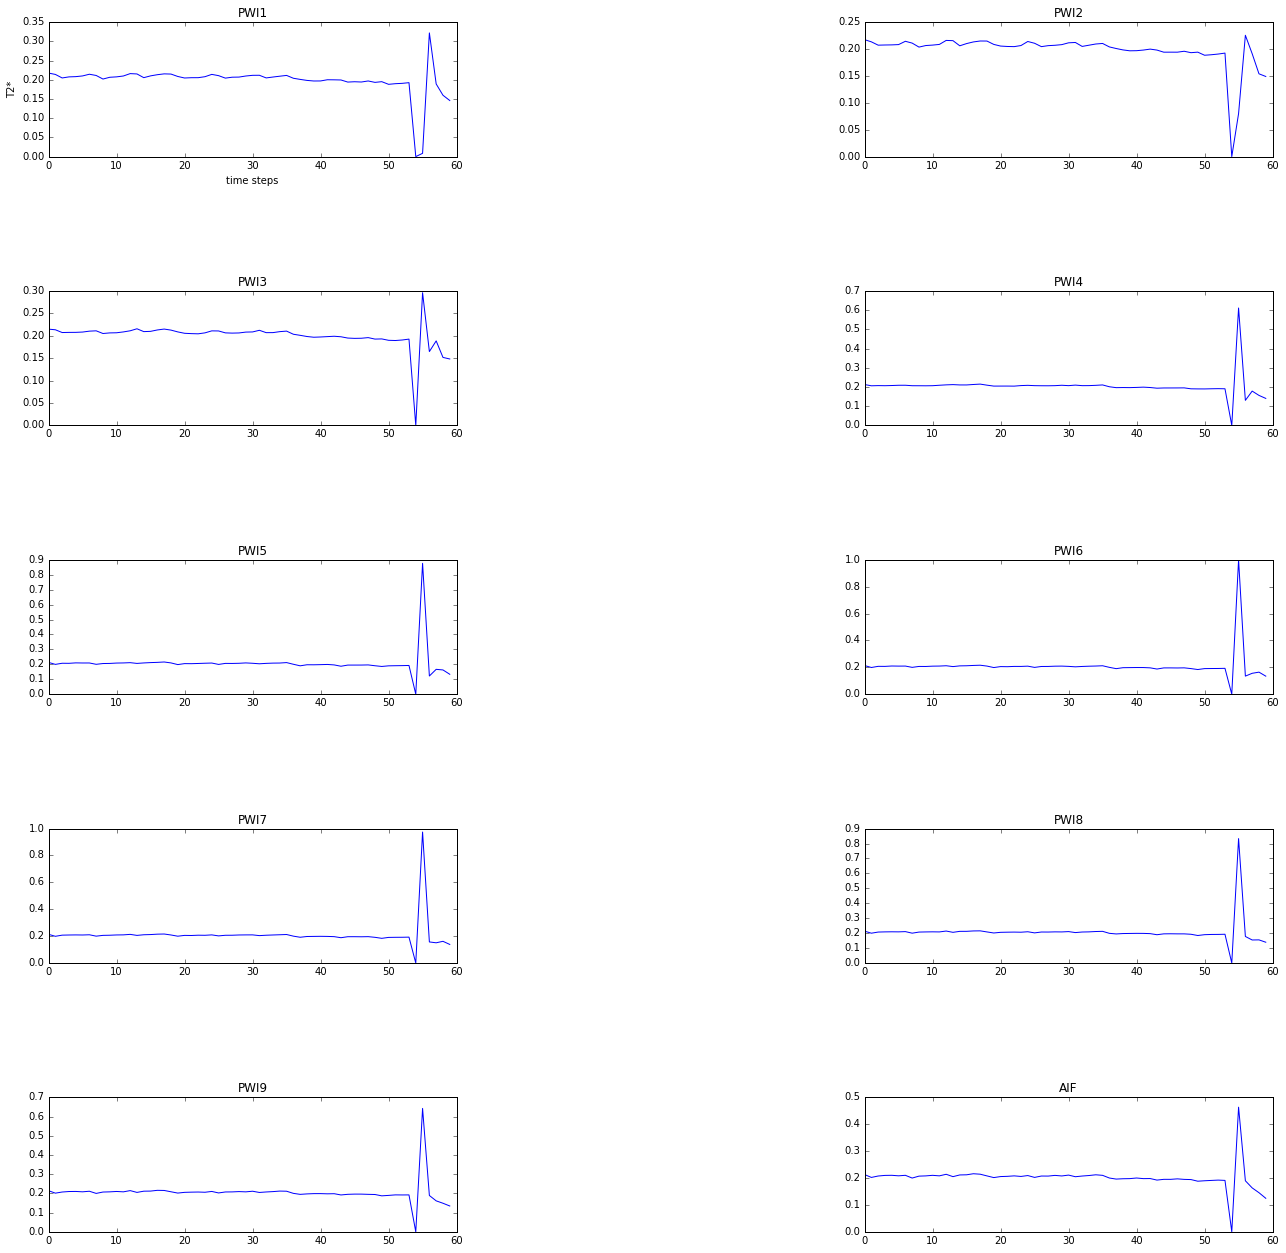

In [8]:
plt.figure(figsize = (20,20))

plt.subplot(521)    
plt.plot(time_series_feats1_reshaped[:,0])
plt.title('PWI1')
plt.xlabel("time steps")
plt.ylabel("T2*")
   
plt.subplot(522)
plt.plot(time_series_feats1_reshaped[:,1])
plt.title('PWI2')
    
plt.subplot(523)
plt.plot(time_series_feats1_reshaped[:,2])
plt.title('PWI3')
    
plt.subplot(524)
plt.plot(time_series_feats1_reshaped[:,3])
plt.title('PWI4')

plt.subplot(525)
plt.plot(time_series_feats1_reshaped[:,4])
plt.title('PWI5')

plt.subplot(526)
plt.plot(time_series_feats1_reshaped[:,5])
plt.title('PWI6')

plt.subplot(527)
plt.plot(time_series_feats1_reshaped[:,6])
plt.title('PWI7')

plt.subplot(528)
plt.plot(time_series_feats1_reshaped[:,7])
plt.title('PWI8')

plt.subplot(529)
plt.plot(time_series_feats1_reshaped[:,8])
plt.title('PWI9')

plt.subplot(5,2,10)
plt.plot(time_series_feats1_reshaped[:,9])
plt.title('AIF')
  
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=1,
                    wspace=1)

    
plt.show()

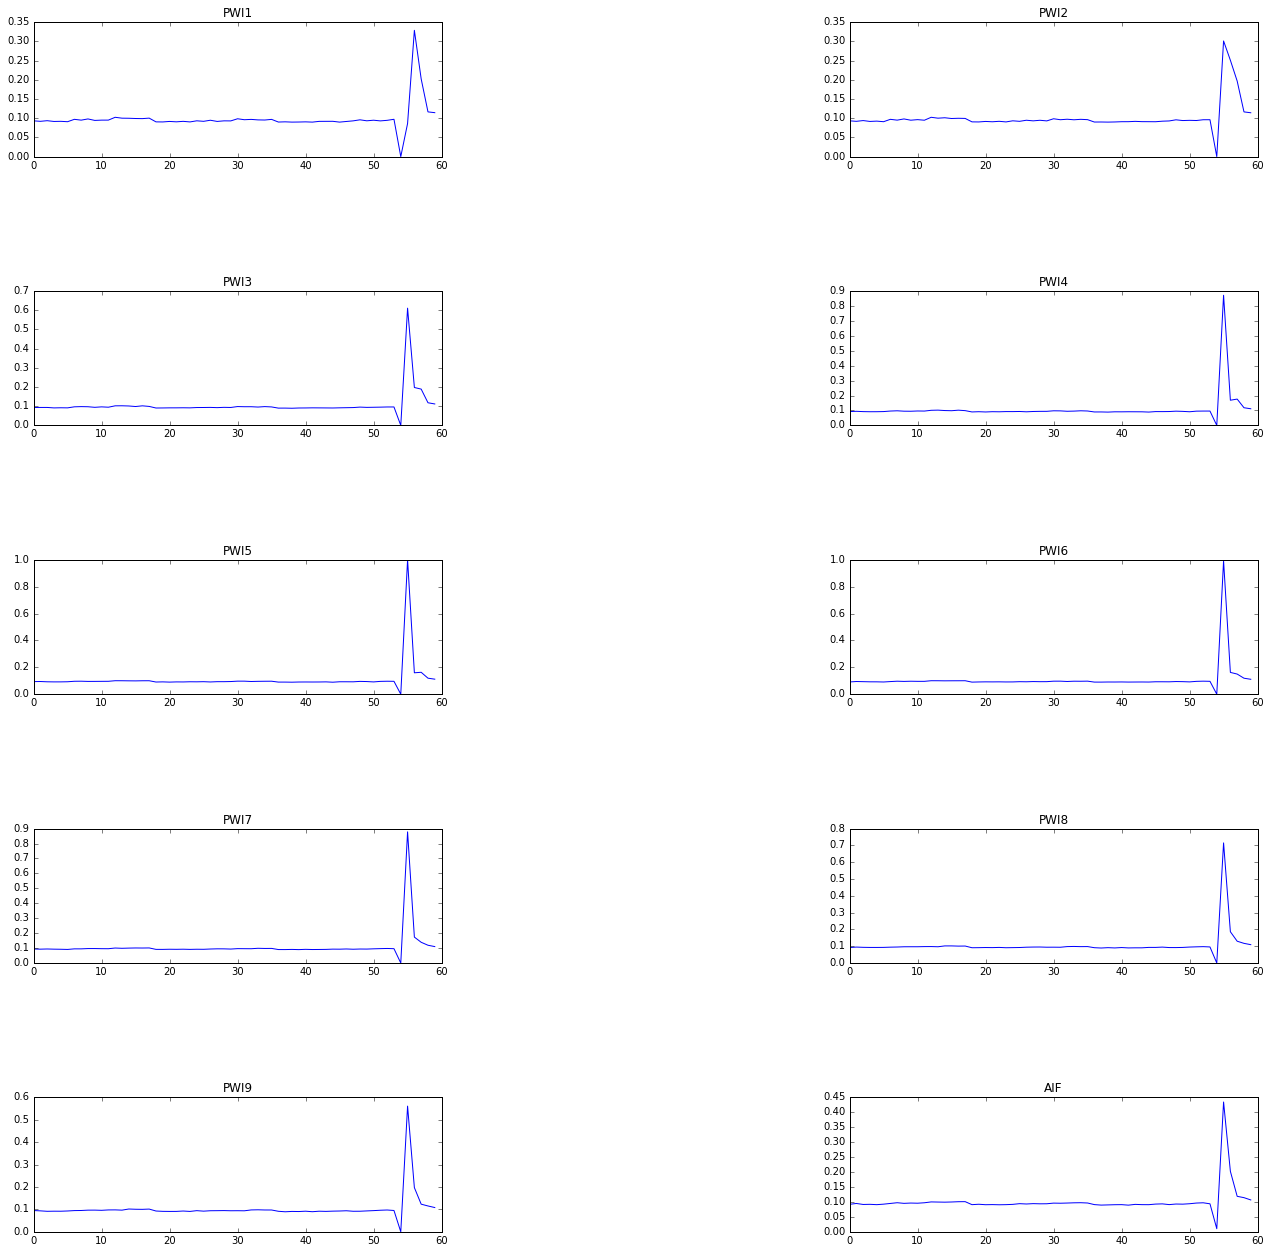

In [9]:
plt.figure(figsize = (20,20))

plt.subplot(521)    
plt.plot(time_series_feats2_reshaped[:,0])
plt.title('PWI1')
   
plt.subplot(522)
plt.plot(time_series_feats2_reshaped[:,1])
plt.title('PWI2')
    
plt.subplot(523)
plt.plot(time_series_feats2_reshaped[:,2])
plt.title('PWI3')
    
plt.subplot(524)
plt.plot(time_series_feats2_reshaped[:,3])
plt.title('PWI4')

plt.subplot(525)
plt.plot(time_series_feats2_reshaped[:,4])
plt.title('PWI5')

plt.subplot(526)
plt.plot(time_series_feats2_reshaped[:,5])
plt.title('PWI6')

plt.subplot(527)
plt.plot(time_series_feats2_reshaped[:,6])
plt.title('PWI7')

plt.subplot(528)
plt.plot(time_series_feats2_reshaped[:,7])
plt.title('PWI8')

plt.subplot(529)
plt.plot(time_series_feats2_reshaped[:,8])
plt.title('PWI9')

plt.subplot(5,2,10)
plt.plot(time_series_feats2_reshaped[:,9])
plt.title('AIF')
  
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=1,
                    wspace=1)

    
plt.show()

## Preparing Data for LSTM

In [10]:
def get_train_test(data, max_id):
    train_data = data[data[0]<max_id]
    test_data = data[data[0]>=max(500,max_id)]
    print(train_data.shape)
    print(test_data.shape)
    train_features = train_data.iloc[:,22:622]
    test_features = test_data.iloc[:,22:622]
    train_labels = train_data.iloc[:,622]
    test_labels = test_data.iloc[:,622]
    train_features_arr = train_features.as_matrix()
    test_features_arr = test_features.as_matrix()
    train_features_reshaped = train_features_arr.reshape(train_data.shape[0],60,10)
    test_features_reshaped = test_features_arr.reshape(test_data.shape[0],60,10)
    print(train_features_reshaped.shape)
    print(test_features_reshaped.shape)
    return train_features_reshaped,test_features_reshaped,train_labels, test_labels
    
    
    
    

In [11]:
def get_hot_value(my_list):
    max_val = max(my_list)
    return [int(item == max_val) for item in my_list]

def fit_lstm(features, labels, batch_size, epochs, pickle_name, test_features, test_labels):

    X = features

    y = np.array(labels)
    y_test = np.array(test_labels)
    #le = preprocessing.LabelEncoder()
    #y = le.fit_transform(y)

    y = y.reshape(-1,1)
    y_test = y_test.reshape(-1,1)
    ohe = OneHotEncoder(sparse=False)
    y = ohe.fit_transform(y)
    
    #ohe = OneHotEncoder(sparse=False)
    y_test = ohe.transform(y_test)
    
    

    model = Sequential()
    model.add(LSTM(60, input_shape=(X[0].shape[0], X[0].shape[1]), return_sequences=False,kernel_initializer='glorot_uniform'))
    #model.add(LSTM(100))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    model.summary()
    from IPython.display import SVG,display
    from keras.utils.vis_utils import model_to_dot
    display(SVG(model_to_dot(model).create(prog='dot', format='svg')))
    
    filepath = str(train_labels.shape[0])+ "_" +"60LSTMweights.best.hdf5"
    es = EarlyStopping(monitor='val_acc', mode='auto', verbose=0)
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

    #es = EarlyStopping(monitor='val_loss', mode='auto', verbose=1)
    
    model.fit(X, y, batch_size=batch_size, epochs=epochs, validation_data = ([test_features],[y_test]),callbacks = [checkpoint])
    
    ##pickle the model    
    #pickle_folder = "pickles/"

    #model.save(pickle_name)  # creates a HDF5 file 'my_model.h5'
    
    return

In [12]:
def test_lstm(test_features, test_labels, pickle_name):
    
    model = load_model(pickle_name)
    
    X = test_features
    y = np.array(test_labels)
    #le = preprocessing.LabelEncoder()
    #y = le.fit_transform(y)

    y = y.reshape(-1,1)
    ohe = OneHotEncoder(sparse=False)
    y = ohe.fit_transform(y)
    
    #Evaluate the model
    scores = model.evaluate(X, y, verbose=1)
    predicted_labels = model.predict(X)

    print("Accuracy: ", scores[1]*100)

    hot_list = [get_hot_value(sublist) for sublist in predicted_labels]

    #t  = np.array(y)
    #p  = np.array(hot_list)
    #t = np.argmax(t, axis=1)
    #p = np.argmax(p, axis=1)

    #print("Precision: ", precision_score(t, p, average=None))
    
    return hot_list, ohe, predicted_labels

(19678, 623)
(7080, 623)
(19678, 60, 10)
(7080, 60, 10)
(19678, 60, 10)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60)                17040     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 122       
Total params: 17,162
Trainable params: 17,162
Non-trainable params: 0
_________________________________________________________________


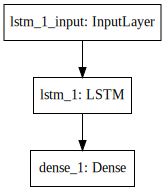

Train on 19678 samples, validate on 7080 samples
Epoch 1/20
19678/19678 [==============================] - 70s 4ms/step - loss: 0.6128 - acc: 0.6668 - val_loss: 0.5889 - val_acc: 0.7449
Epoch 2/20
19678/19678 [==============================] - 68s 3ms/step - loss: 0.5750 - acc: 0.6958 - val_loss: 0.5859 - val_acc: 0.7257
Epoch 3/20
19678/19678 [==============================] - 67s 3ms/step - loss: 0.5605 - acc: 0.7086 - val_loss: 0.5688 - val_acc: 0.7405
Epoch 4/20
19678/19678 [==============================] - 68s 3ms/step - loss: 0.5380 - acc: 0.7204 - val_loss: 0.5885 - val_acc: 0.6986
Epoch 5/20
19678/19678 [==============================] - 68s 3ms/step - loss: 0.5193 - acc: 0.7296 - val_loss: 0.5747 - val_acc: 0.7339
Epoch 6/20
19678/19678 [==============================] - 68s 3ms/step - loss: 0.5057 - acc: 0.7365 - val_loss: 0.6120 - val_acc: 0.7042
Epoch 7/20
19678/19678 [==============================] - 68s 3ms/step - loss: 0.4858 - acc: 0.7562 - val_loss: 0.5759 - val_acc:

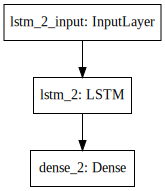

Train on 27461 samples, validate on 7080 samples
Epoch 1/20
27461/27461 [==============================] - 92s 3ms/step - loss: 0.5952 - acc: 0.6862 - val_loss: 0.5778 - val_acc: 0.7442
Epoch 2/20
27461/27461 [==============================] - 93s 3ms/step - loss: 0.5774 - acc: 0.6968 - val_loss: 0.5594 - val_acc: 0.7462
Epoch 3/20
27461/27461 [==============================] - 88s 3ms/step - loss: 0.5670 - acc: 0.7082 - val_loss: 0.5875 - val_acc: 0.7405
Epoch 4/20
27461/27461 [==============================] - 88s 3ms/step - loss: 0.5405 - acc: 0.7270 - val_loss: 0.6369 - val_acc: 0.6890
Epoch 5/20
27461/27461 [==============================] - 4775s 174ms/step - loss: 0.5136 - acc: 0.7458 - val_loss: 0.6692 - val_acc: 0.5621
Epoch 6/20
27461/27461 [==============================] - 101s 4ms/step - loss: 0.4786 - acc: 0.7731 - val_loss: 0.6452 - val_acc: 0.6137
Epoch 7/20
27461/27461 [==============================] - 100s 4ms/step - loss: 0.4423 - acc: 0.7954 - val_loss: 0.9210 - va

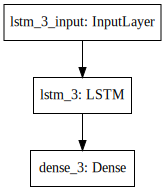

Train on 29835 samples, validate on 7080 samples
Epoch 1/20
29835/29835 [==============================] - 107s 4ms/step - loss: 0.5911 - acc: 0.6854 - val_loss: 0.5827 - val_acc: 0.7299
Epoch 2/20
29835/29835 [==============================] - 106s 4ms/step - loss: 0.5915 - acc: 0.6818 - val_loss: 0.5762 - val_acc: 0.7514
Epoch 3/20
29835/29835 [==============================] - 106s 4ms/step - loss: 0.5674 - acc: 0.6990 - val_loss: 0.5800 - val_acc: 0.7516
Epoch 4/20
29835/29835 [==============================] - 107s 4ms/step - loss: 0.5534 - acc: 0.7053 - val_loss: 0.6264 - val_acc: 0.5818
Epoch 5/20
29835/29835 [==============================] - 111s 4ms/step - loss: 0.5315 - acc: 0.7257 - val_loss: 0.6533 - val_acc: 0.6610
Epoch 6/20
29835/29835 [==============================] - 115s 4ms/step - loss: 0.5198 - acc: 0.7327 - val_loss: 0.6091 - val_acc: 0.6921
Epoch 7/20
29835/29835 [==============================] - 133s 4ms/step - loss: 0.4964 - acc: 0.7493 - val_loss: 0.6306 - v

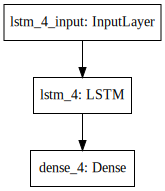

Train on 37210 samples, validate on 7080 samples
Epoch 1/20
37210/37210 [==============================] - 139s 4ms/step - loss: 0.5850 - acc: 0.6968 - val_loss: 0.5697 - val_acc: 0.7442
Epoch 2/20
37210/37210 [==============================] - 128s 3ms/step - loss: 0.5561 - acc: 0.7102 - val_loss: 0.5918 - val_acc: 0.7414
Epoch 3/20
37210/37210 [==============================] - 142s 4ms/step - loss: 0.5332 - acc: 0.7289 - val_loss: 0.5932 - val_acc: 0.7049
Epoch 4/20
37210/37210 [==============================] - 158s 4ms/step - loss: 0.4882 - acc: 0.7704 - val_loss: 0.7453 - val_acc: 0.6347
Epoch 5/20
37210/37210 [==============================] - 165s 4ms/step - loss: 0.4335 - acc: 0.8011 - val_loss: 1.0216 - val_acc: 0.6223
Epoch 6/20
37210/37210 [==============================] - 155s 4ms/step - loss: 0.3972 - acc: 0.8195 - val_loss: 1.1628 - val_acc: 0.6105
Epoch 7/20
37210/37210 [==============================] - 148s 4ms/step - loss: 0.3764 - acc: 0.8292 - val_loss: 1.1516 - v

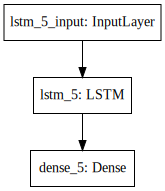

Train on 42507 samples, validate on 7080 samples
Epoch 1/20
42507/42507 [==============================] - 148s 3ms/step - loss: 0.5675 - acc: 0.7105 - val_loss: 0.6088 - val_acc: 0.7164
Epoch 2/20
42507/42507 [==============================] - 159s 4ms/step - loss: 0.5535 - acc: 0.7187 - val_loss: 0.6437 - val_acc: 0.6596
Epoch 3/20
42507/42507 [==============================] - 171s 4ms/step - loss: 0.5197 - acc: 0.7430 - val_loss: 0.6494 - val_acc: 0.6709
Epoch 4/20
42507/42507 [==============================] - 188s 4ms/step - loss: 0.4755 - acc: 0.7779 - val_loss: 0.6304 - val_acc: 0.6384
Epoch 5/20
42507/42507 [==============================] - 192s 5ms/step - loss: 0.4489 - acc: 0.7954 - val_loss: 0.7467 - val_acc: 0.6476
Epoch 6/20
42507/42507 [==============================] - 214s 5ms/step - loss: 0.4099 - acc: 0.8192 - val_loss: 0.5828 - val_acc: 0.7400
Epoch 7/20
42507/42507 [==============================] - 209s 5ms/step - loss: 0.3814 - acc: 0.8347 - val_loss: 0.6753 - v

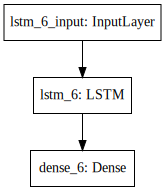

Train on 42920 samples, validate on 7080 samples
Epoch 1/20
42920/42920 [==============================] - 152s 4ms/step - loss: 0.5684 - acc: 0.7140 - val_loss: 0.6038 - val_acc: 0.7422
Epoch 2/20
42920/42920 [==============================] - 148s 3ms/step - loss: 0.5438 - acc: 0.7257 - val_loss: 0.6873 - val_acc: 0.6484
Epoch 3/20
42920/42920 [==============================] - 149s 3ms/step - loss: 0.5044 - acc: 0.7565 - val_loss: 0.7464 - val_acc: 0.6216
Epoch 4/20
42920/42920 [==============================] - 153s 4ms/step - loss: 0.4504 - acc: 0.7930 - val_loss: 0.9074 - val_acc: 0.6061
Epoch 5/20
42920/42920 [==============================] - 153s 4ms/step - loss: 0.4192 - acc: 0.8078 - val_loss: 1.0462 - val_acc: 0.6212
Epoch 6/20
42920/42920 [==============================] - 149s 3ms/step - loss: 0.3939 - acc: 0.8200 - val_loss: 1.0327 - val_acc: 0.6212
Epoch 7/20
42920/42920 [==============================] - 148s 3ms/step - loss: 0.3792 - acc: 0.8296 - val_loss: 1.3790 - v

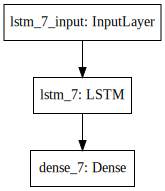

Train on 47512 samples, validate on 2488 samples
Epoch 1/20
47512/47512 [==============================] - 162s 3ms/step - loss: 0.5677 - acc: 0.7129 - val_loss: 0.6058 - val_acc: 0.7472
Epoch 2/20
47512/47512 [==============================] - 160s 3ms/step - loss: 0.5388 - acc: 0.7310 - val_loss: 0.6404 - val_acc: 0.7504
Epoch 3/20
47512/47512 [==============================] - 160s 3ms/step - loss: 0.4931 - acc: 0.7630 - val_loss: 0.5762 - val_acc: 0.7673
Epoch 4/20
47512/47512 [==============================] - 160s 3ms/step - loss: 0.4481 - acc: 0.7932 - val_loss: 0.5877 - val_acc: 0.7106
Epoch 5/20
47512/47512 [==============================] - 162s 3ms/step - loss: 0.4126 - acc: 0.8136 - val_loss: 1.0208 - val_acc: 0.5072
Epoch 6/20
47512/47512 [==============================] - 165s 3ms/step - loss: 0.3861 - acc: 0.8279 - val_loss: 2.2749 - val_acc: 0.4397
Epoch 7/20
47512/47512 [==============================] - 158s 3ms/step - loss: 0.3664 - acc: 0.8388 - val_loss: 1.3447 - v

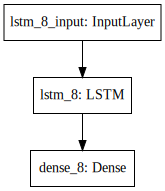

Train on 48850 samples, validate on 1150 samples
Epoch 1/20
48850/48850 [==============================] - 149s 3ms/step - loss: 0.5691 - acc: 0.7147 - val_loss: 0.6272 - val_acc: 0.5530
Epoch 2/20
48850/48850 [==============================] - 146s 3ms/step - loss: 0.5519 - acc: 0.7233 - val_loss: 0.5975 - val_acc: 0.7026
Epoch 3/20
48850/48850 [==============================] - 147s 3ms/step - loss: 0.5328 - acc: 0.7361 - val_loss: 0.6429 - val_acc: 0.4774
Epoch 4/20
48850/48850 [==============================] - 146s 3ms/step - loss: 0.4901 - acc: 0.7626 - val_loss: 2.4416 - val_acc: 0.3539
Epoch 5/20
48850/48850 [==============================] - 154s 3ms/step - loss: 0.4491 - acc: 0.7901 - val_loss: 2.4771 - val_acc: 0.3548
Epoch 6/20
48850/48850 [==============================] - 149s 3ms/step - loss: 0.4121 - acc: 0.8062 - val_loss: 3.1471 - val_acc: 0.3557
Epoch 7/20
48850/48850 [==============================] - 150s 3ms/step - loss: 0.3804 - acc: 0.8288 - val_loss: 2.9387 - v

In [13]:
max_ids = [200,300,350,400,450,500,550,650]
for max_id in max_ids:
    train_features_reshaped, test_features_reshaped,train_labels,test_labels = get_train_test(data,max_id)
    print(train_features_reshaped.shape)
    fit_lstm(train_features_reshaped, train_labels, 32, 20, 'lstm' + str(train_features_reshaped.shape[0]) + 'samples.h5', test_features_reshaped, test_labels)
    #lstm_predicted_labels,ohe,predicted_probs = test_lstm(test_features_reshaped, test_labels.as_matrix(), 'lstm_42ksamples.h5')

In [53]:
lstm_predicted_labels,ohe,predicted_probs = test_lstm(test_features_reshaped, test_labels.as_matrix(), 'lstm42920samples.h5')

7080/7080 [==============================] - 8s 1ms/step
Accuracy:  75.16949152542372


In [54]:
from sklearn.metrics import roc_curve
fpr,tpr,thresholds = roc_curve(test_labels.as_matrix(), predicted_probs[:,1])
from sklearn.metrics import auc
auc = auc(fpr, tpr)


In [55]:
auc

0.741325629014614

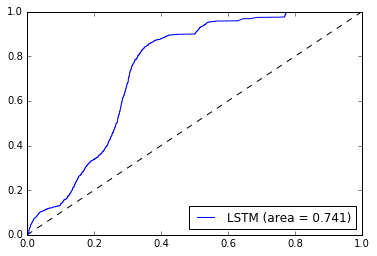

In [56]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='LSTM (area = {:.3f})'.format(auc))
plt.legend(loc='best')
plt.title("")
plt.show()

In [103]:
lstm_labels_decoded = [0]*len(lstm_predicted_labels)
for i in range(len(lstm_predicted_labels)):
    if lstm_predicted_labels[i] == [1,0]:
        lstm_labels_decoded[i] = 0
    else:
        lstm_labels_decoded[i] = 1
        
print(lstm_labels_decoded)

[1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 

In [78]:
train_features_18 = train_data[[4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]]
test_features_18 = test_data[[4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21]]

model_dec_tree = DecisionTreeClassifier(random_state = 42)

model_dec_tree.fit(train_features_18, train_labels)
dectree_predicted_labels = model_dec_tree.predict(test_features_18)
print(accuracy_score(test_labels,dectree_predicted_labels))

0.6954802259887005


In [107]:
print(len(lstm_labels_decoded))
print(len(dectree_predicted_labels))

7080
7080
